<a href="https://colab.research.google.com/github/matheusomendonca/general/blob/main/multicriteria_ifood_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# libraries
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import urllib.parse

In [28]:
# find latitude and longitude from address
address = 'Avenida Fleming, Belo Horizonte'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
location_response = requests.get(url).json()
lat, lon = location_response[0]["lat"], location_response[0]["lon"]

In [29]:
# ifood request
search_term = "pizza"
url = f"https://marketplace.ifood.com.br/v2/search?latitude={lat}&longitude={lon}&channel=IFOOD&page=0&size=100&term={search_term}"
ifood_response = requests.get(url).json()

In [30]:
# collect price and rating info
data = {"merchant_name": [],
        "item_name": [],
        "price": [],
        "rating": []}

rating_list = []

items = ifood_response['items']['data']
for item in items:

  # item name
  data["item_name"].append(item['name'])

  # collected prices
  minimum_price = item.get('minimumPrice', 0)
  original_price = item.get('originalPrice', 1000)
  price = item.get('price', 1000)

  # adjusted price
  adjusted_price = max(minimum_price, min(original_price, price))

  # delivery fee
  delivery_fee = item["merchant"]["deliveryFee"]['value']

  # total price
  total_price = adjusted_price + delivery_fee
  data["price"].append(total_price)
  
  # merchant rating
  merchant_rating = item["merchant"]["userRating"]
  data["rating"].append(merchant_rating)

  # merchant name
  merchant_name = item["merchant"]["name"]
  data["merchant_name"].append(merchant_name)

In [31]:
# convert to DataFrame
data = pd.DataFrame(data)
data.head(10)

,merchant_name,item_name,price,rating
0,Zerlotini's Pizza,Pizza doce brotinho+pizza salgada grande+Coca ...,69.90,4.55660
1,Pizzaria Varanda (castelo),Pizza gg+pizza broto prestigio.,89.90,3.62745
2,Varanda Burgueria Castelo,Pizza gg+pizza broto prestigio,96.90,3.00000
3,Pizza Sur Liberdade,1 pizza 30 cm Marguerita + 1 Pizza 30 cm milh...,95.38,4.23901
4,Oh!kipizza,Pizza gigante + pizza doce + refrigerante,83.89,4.61376
5,Oh!kipizza,Pizza gigante + pizza média+coca 2 litros,86.89,4.61376
6,Pizza Sur Liberdade,Pizza 30 cm Portuguesa + 1 Pizza de brigadeiro...,97.16,4.23901
7,Telepizza e Sanduiche do Grilo,"pizza 4 sabores na mesma pizza, (A MODA, PRESU...",41.99,4.33333
8,Massa Bar & Pizzaria,Combo Pizza Gg Frango + Pizza Gg Calabresa + 2...,126.85,4.90000
9,Pizza Anapolis,Pizza Gigante Gourmet +Pizza Doce Individual +...,145.90,4.72311


In [32]:
# filter extreme ratings, keeping values in the range .01 < rating < 4.99
rating_filter = (data['rating'] > 0.01) & (data['rating'] < 4.99)
filtered_data = data[rating_filter]

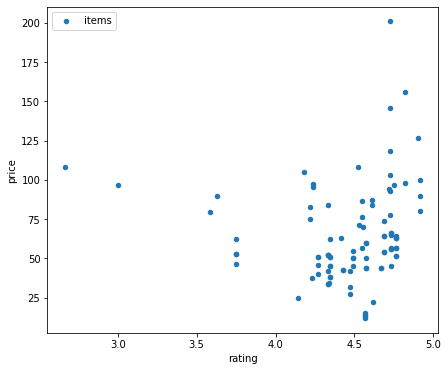

In [33]:
# price vs rating plot
filtered_data.plot(x='rating',
                   y='price',
                   kind='scatter',
                   label='items',
                   figsize=(7, 6));

In [34]:
def pareto_set(fx):
  """Identification of a Pareto subset.

      Args:
          fx: (n x m)-array of n functions and m points.

      Output:
          ip: (m)-list of booleans indicating whether i in [0,m-1] is non-dominated.
  """

  # number of points
  m = fx.shape[1]

  # Pareto comparison
  ip = [True] * m
  for i in range(m):
      fxm = np.tile(fx[:, i].reshape(-1, 1), (1, m))
      if np.any(np.all(fxm >= fx, 0) & np.any(fxm != fx, 0)):
          ip[i] = False  # is non-dominated

  return ip

In [35]:
# objectives
fx = filtered_data[['rating', 'price']].values.T

# we want minimum price and maximum rating, since pareto_set deals with
# minimization problem, rating must be multiplied by -1
fx[0, :] = -fx[0, :]

In [36]:
# find non-dominated points
is_nondomitated = pareto_set(fx)

In [37]:
# plot non-dominated items
nondominated = filtered_data[is_nondomitated]
dominated = filtered_data[np.logical_not(is_nondomitated)]

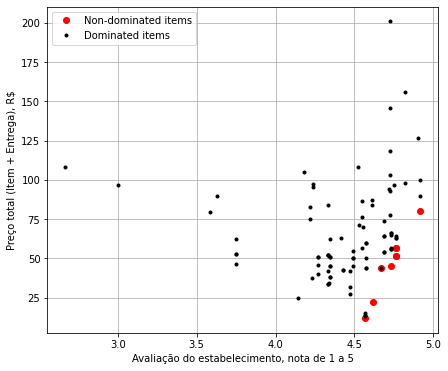

In [38]:
# non-dominated plot
_, ax = plt.subplots(figsize=(7, 6))
ax.plot(nondominated['rating'],
        nondominated['price'],
        'ro',
        label="Non-dominated items")
ax.plot(dominated['rating'],
        dominated['price'],
        'k.',
        label="Dominated items")
plt.legend()
plt.grid()
plt.xlabel('Avaliação do estabelecimento, nota de 1 a 5')
plt.ylabel('Preço total (Item + Entrega), R$')
plt.show()

In [39]:
# non-dominated items
nondominated

,merchant_name,item_name,price,rating
17,Californiana Pizzas e Massas,Pizza PIZZA 25CM 2 SABORES (4 PEDAÇOS),51.49,4.76106
23,Pizza Top Sanduiches,Mega Promoção (4 sabores em 1 pizza) PIZZA GIG...,43.87,4.66667
31,Pizza Guanabara,Acréscimo de Pizza ACRÉSCIMO DE PIZZA MÉDIA,11.99,4.56757
36,Californiana Pizzas e Massas,Pizza PIZZA 25CM (4 PEDAÇOS),51.49,4.76106
38,O Fornês - Pizzaria Bh,1 pizza média + 1 pizza doce média,79.90,4.91667
46,Açaí Mais Liberdade,01 mini pizza de frango /01 mini pizza presunt...,21.91,4.61818
74,Roça Bar e Pizzaria,Pizzas PIZZA GRANDE (6 PEDAÇOS),56.49,4.76316
83,Roça Bar e Pizzaria,Pizzas PIZZA GRANDE 2 SABORES (6 PEDAÇOS),56.49,4.76316
96,Stop Pizza Bh,Pizzas doces. PIZZA BROTINHO (18CM - 2 FATIAS),44.89,4.73460
